# BET method

This is a simple Python-based notebook to load an adsorption isotherm and apply the BET method to determine a surface area. It follows the recommendations of Rouquerol et al, and the reader is encouraged to read the papers below to understand how the fit should be performed, as well as the limitations of the method (in particular for microporous adsorbents).

The code assumes that the adsorbate is N₂ at 77 K.

## References

- [“Recommendations for the characterization of porous solids”](https://doi.org/10.1351/pac199466081739), J. Rouquerol, D. Avnir, C. W. Fairbridge, D. H. Everett, J. M. Haynes, N. Pernicone, J. D. F. Ramsay, K. S. W. Sing and K. K. Unger, *Pure Appl. Chem.* **1994**, 66 (8), 1739–1758
- [“Is the BET equation applicable to microporous adsorbents?”](https://doi.org/10.1016/S0167-2991(07)80008-5), J. Rouquerol, P. Llewellyn and F. Rouquerol, *Studies in Surface Science and Catalysis* **2007**, 160, 49–56
- [“Physisorption of gases, with special reference to the evaluation of surface area and pore size distribution”](https://doi.org/10.1515/pac-2014-1117), M. Thommes, K. Kaneko, A. V. Neimark, J. P. Olivier, F. Rodriguez-Reinoso, J. Rouquerol and K. S. W. Sing, *Pure Appl. Chem.* **2015**, 87 (9–10), 1051–1069
- [ISO 9277:2010(E) standard](https://www.iso.org/standard/44941.html), “Determination of the specific surface area of solids by gas adsorption — BET method”, Second edition 2010-09-01


## Code

In [1]:
%matplotlib inline
import csv
import matplotlib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
def readIsothermFromCSVFile(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
        return readIsothermFromString(lines)

def readIsothermFromString(s):
    reader = csv.reader(s)
    data = []
    for x, y in reader:
        try:
            x = float(x)
            y = float(y)
            data.append([x,y])
        except ValueError as e:
            pass
    data.sort()
    return data

def isothermProperties(data):
    pmin = min(x for x,y in data)
    pmax = max(x for x,y in data)
    nmin = min(y for x,y in data)
    nmax = max(y for x,y in data)
    print(f'Number of data points: {len(data)}')
    print(f'Minimal value of P/P°: {pmin:.4f}')
    print(f'Maximal value of P/P°: {pmax:.4f}')
    print(f'Minimal value of uptake: {nmin:.1f}')
    print(f'Maximal value of uptake: {nmax:.1f}')

    
def plotIsotherm(data):
    nmax = max(y for x, y in data)
    plt.title('Adsorption isotherm')
    plt.xlabel('P / P°')
    plt.ylabel('Nads')
    plt.axis([0, 1, 0, 1.1*nmax])
    plt.plot(*zip(*data), 'c-')
    plt.plot(*zip(*data), 'b+')
    plt.show()
    
def plotBET(data, xplotmax, xregmin, xregmax):
    fig, (plot1, plot2) = plt.subplots(2, sharex=True)
    fig.suptitle('BET plots')

    # All data for BET plot
    bet = [[x, x/(1-x)/y] for x,y in data if x <= xplotmax]
    betmax = max(y for x,y in bet)

    # All data for Rouquerol plot
    bet2 = [[x, y*(1-x)] for x,y in data if x <= xplotmax]
    bet2max = max(y for x,y in bet2)

    # Rouquerol plot within the regression window
    bet2reg = [y*(1-x) for x,y in data if xregmin <= x <= xregmax]
    Rouquerol_increasing = True
    for i in range(1, len(bet2reg)):
        if bet2reg[i] < bet2reg[i-1]:
            Rouquerol_increasing = False
            break

    # Perform the linear regression
    betreg = [[x, x/(1-x)/y] for x,y in data if xregmin <= x <= xregmax]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(*zip(*betreg))
    
    BET_C = slope/intercept + 1
    BET_nmono = 1/(intercept*BET_C)
    BET_surf = BET_nmono / 0.02241396954e6 * 0.162e-18 * 6.02214076e23

    plot1.set(ylabel='')
    plot1.axis([0, xplotmax, 0, 1.1*betmax])
    plot1.plot(*zip(*bet), 'c-')
    plot1.plot([0, 1], [intercept, intercept+slope], 'r--')
    plot1.plot([xregmin, xregmin], [0, 2*betmax], 'g--')
    plot1.plot([xregmax, xregmax], [0, 2*betmax], 'g--')
    plot1.plot(*zip(*bet), 'b+')
    
    plot2.set(xlabel='P / P°', ylabel='')
    plot2.axis([0, xplotmax, 0, 1.1*bet2max])
    plot2.plot(*zip(*bet2), 'c-')
    plot2.plot([xregmin, xregmin], [0, 2*bet2max], 'g--')
    plot2.plot([xregmax, xregmax], [0, 2*bet2max], 'g--')
    plot2.plot(*zip(*bet2), 'b+')
    
    if BET_C > 0:
        print(f'✅ C = {BET_C:.2f} is positive')
    else:
        print(f'🔴 C = {BET_C:.2f} should be positive')

    nmaxfit = max(y for x,y in data if xregmin <= x <= xregmax)
    if BET_nmono <= nmaxfit:
        print(f'✅ nmono = {BET_nmono:.2f} is within BET range (up to {nmaxfit:.2f})')
    else:
        print(f'🔴 nmono = {BET_nmono:.2f} is outside BET range (up to {nmaxfit:.2f})')
        
    if Rouquerol_increasing:
        print(f'✅ Rouquerol plot increasing in fit range')
    else:
        print(f'🔴 Rouquerol plot should be increasing in fit range')

    print(f'R^2 = {r_value**2:.4f}')
    print(f'\nSurface area = {BET_surf:.3f} m^2/g')

## Example of use: carbon black

We use an adsorption isotherm for carbon black, taken from https://github.com/Micromeritics/micromeritics/blob/master/micromeritics/tests/test_bet.py

First, we load the data from the CSV file (first column: P/P°; second column: uptake in cm^3 STP / g), we checks its characteristics and plot it.

Number of data points: 44
Minimal value of P/P°: 0.0434
Maximal value of P/P°: 0.9002
Minimal value of uptake: 4.4
Maximal value of uptake: 18.2


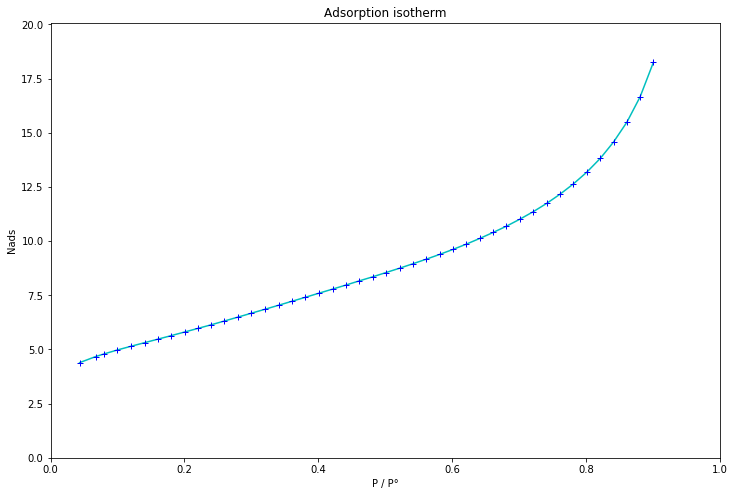

In [3]:
data = readIsothermFromCSVFile("carbon_black.csv")
isothermProperties(data)
plotIsotherm(data)

We are now making the BET fit. This function takes four parameters:
- the isotherm
- the maximal pressure for plotting the data (which only impacts the plot, not the BET fit)
- the window for BET fit, i.e. the minimal and maximal pressure used in the BET fit

In this case, we decide to do the BET fit on the range of P/P° between 0.05 and 0.25, where the BET plot (first plot) is quite linear and the Rouquerol plot (second plot) is increasing. This fitting window is indicated in the plots by vertical green dashed lines. The plots extend beyond the fitting window, up to P/P° = 0.6, so we can see the larger picture.

✅ C = 139.69 is positive
✅ nmono = 4.77 is within BET range (up to 6.14)
✅ Rouquerol plot increasing in fit range
R^2 = 1.0000

Surface area = 20.769 m^2/g


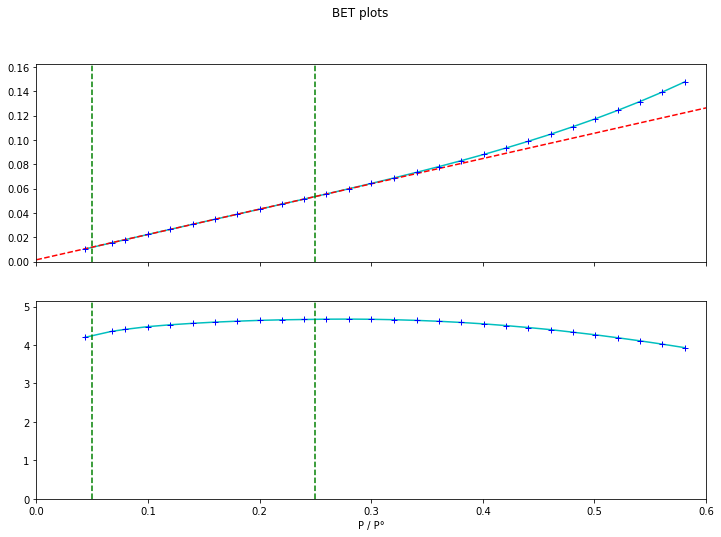

In [4]:
plotBET(data, 0.6, 0.05, 0.25)

We see that all conditions for BET fit are satisfied, and the linear regression is suitable as well. The surface area is measured at 20.8 m²/g for this sample.

## Second example: metal–organic framework

We are now looking at the isotherm for M-DUT-48, reported in [Lohe et al.](https://doi.org/10.1039/C0CC05278G) (Figure S5) and digitized by the [NIST/ARPA-E Database of Novel and Emerging Adsorbent Materials](https://adsorbents.nist.gov/isodb/index.php?DOI=10.1039/C0cc05278g)

Number of data points: 23
Minimal value of P/P°: 0.0070
Maximal value of P/P°: 0.9385
Minimal value of uptake: 299.0
Maximal value of uptake: 496.2


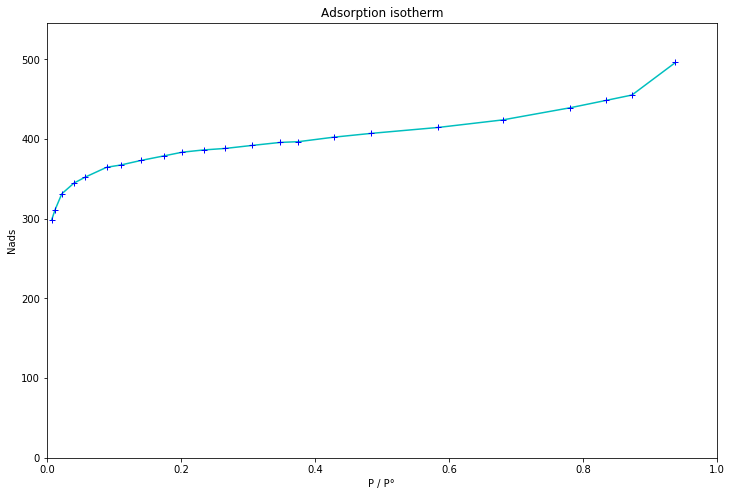

In [5]:
data = readIsothermFromCSVFile("M-DUT-4.csv")
isothermProperties(data)
plotIsotherm(data)

🔴 C = -222.04 should be positive
✅ nmono = 310.08 is within BET range (up to 378.88)
🔴 Rouquerol plot should be increasing in fit range
R^2 = 0.9988

Surface area = 1349.661 m^2/g


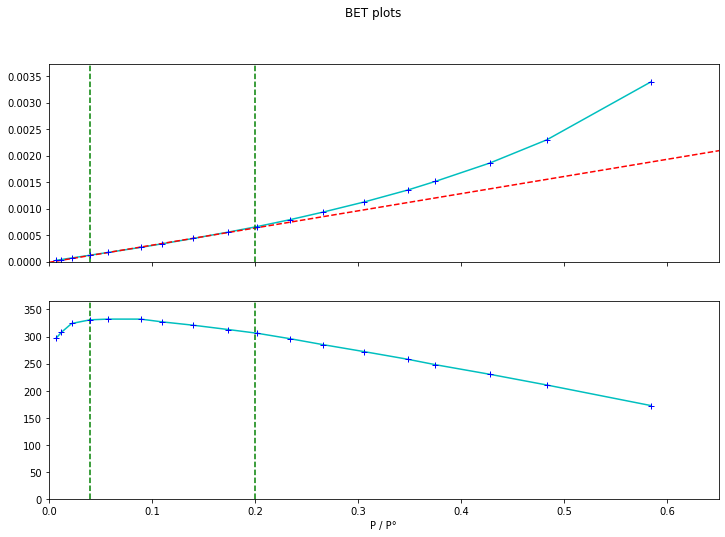

In [6]:
plotBET(data, 0.65, 0.04, 0.2)

The value reported in the paper for M-DUT-4 is 1346 m²/g. Depending on the fitting range chosen, you can find values close to that, as shown above where you find 1349 m²/g for the range 0.04 to 0.2. However, those ranges do not necessarily fulfill all the contraints.

✅ C = 893.21 is positive
✅ nmono = 338.90 is within BET range (up to 352.32)
✅ Rouquerol plot increasing in fit range
R^2 = 1.0000

Surface area = 1475.089 m^2/g


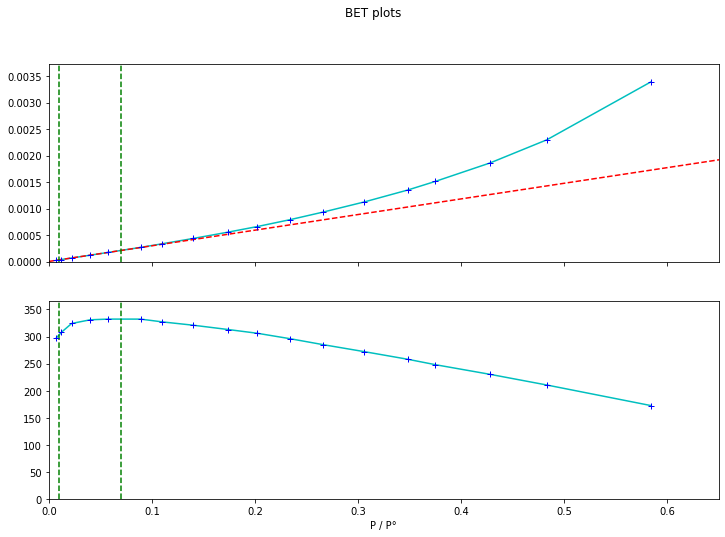

In [7]:
plotBET(data, 0.65, 0.01, 0.07)

Another fitting on a narrower range gives a value of 1475 m²/g for the surface area. It is therefore important to be aware of the impact of data processing and fitting when quoting and discussing BET surface areas.